<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Data_V2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
import cv2
from google.colab import files

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/balanced_dataset"

def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).resize((224, 224))
            img = np.array(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

healthy_folder = os.path.join(dataset_path, "healthy")
healthy_images, healthy_labels = load_images_from_folder(healthy_folder, label=0)

non_healthy_folder = os.path.join(dataset_path, "non_healthy")
non_healthy_images, non_healthy_labels = load_images_from_folder(non_healthy_folder, label=1)

X = np.concatenate((healthy_images, non_healthy_images), axis=0)
y = np.concatenate((healthy_labels, non_healthy_labels), axis=0)

print(f"Total images loaded: {X.shape[0]}")
print(f"Healthy images: {healthy_images.shape[0]}")
print(f"Non-healthy images: {non_healthy_images.shape[0]}")

Total images loaded: 3714
Healthy images: 1857
Non-healthy images: 1857


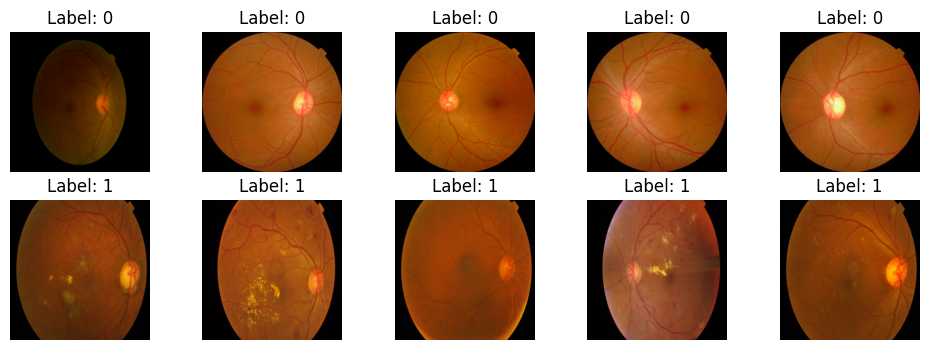

In [ ]:
def show_sample_images(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)

    plt.figure(figsize=(12, 2 * len(unique_labels)))

    for label_index, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_labels = labels[label_indices]

        for i in range(num_images_per_label):
            plt.subplot(len(unique_labels), num_images_per_label, label_index * num_images_per_label + i + 1)
            plt.imshow(label_images[i])
            plt.title(f"Label: {label_labels[i]}")
            plt.axis('off')

    plt.show()

show_sample_images(X, y, num_images_per_label=5)

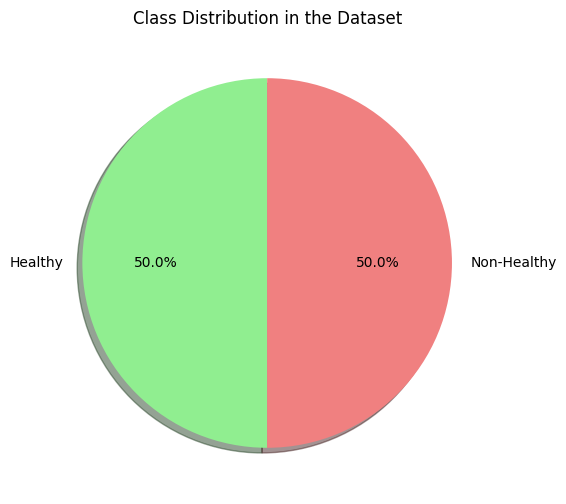

In [ ]:
healthy_count = np.sum(y == 0)
non_healthy_count = np.sum(y == 1)

labels = ['Healthy', 'Non-Healthy']

sizes = [healthy_count, non_healthy_count]

colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    clahe_image = clahe.apply(gray_image)

    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

    return clahe_image

X_clahe = np.array([apply_clahe(image) for image in X])

print(f"Shape of CLAHE-processed dataset: {X_clahe.shape}")

Shape of CLAHE-processed dataset: (3714, 224, 224, 3)


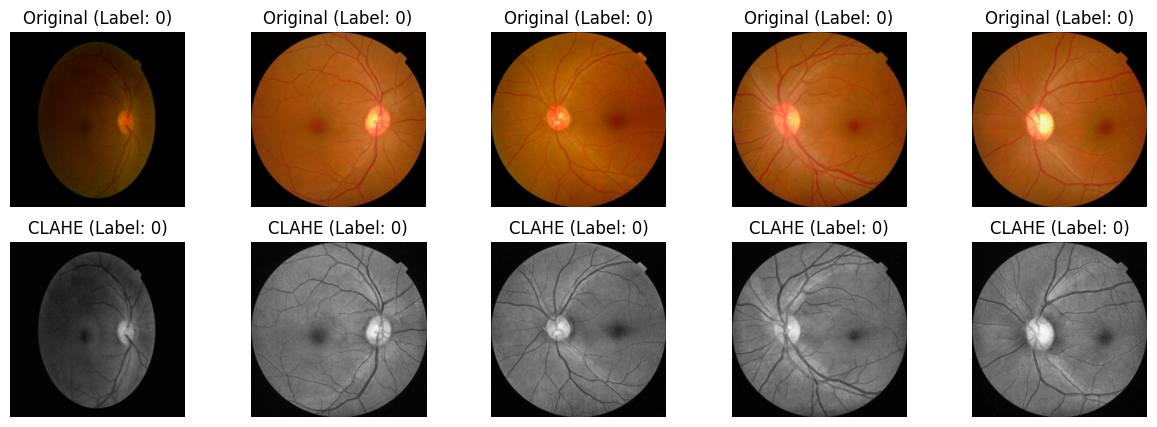

In [ ]:
def show_original_vs_clahe(original_images, clahe_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original (Label: {y[i]})")
        plt.axis('off')

        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(clahe_images[i])
        plt.title(f"CLAHE (Label: {y[i]})")
        plt.axis('off')
    plt.show()

show_original_vs_clahe(X, X_clahe, num_images=5)

In [ ]:
np.save("/content/drive/MyDrive/dataset/X_clahe.npy", X_clahe)

In [ ]:
X_clahe_normalized = X_clahe / 255.0


# Split the Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clahe_normalized, y, test_size=0.1, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 3342 images
Testing set: 372 images


#CNN Model

In [ ]:
def build_cnn_model(input_shape=(224, 224, 3)):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

model = build_cnn_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 77s 690ms/step - accuracy: 0.8399 - loss: 0.3701 - val_accuracy: 0.8898 - val_loss: 0.2632
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 659ms/step - accuracy: 0.9121 - loss: 0.2254 - val_accuracy: 0.9113 - val_loss: 0.2190
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 69s 652ms/step - accuracy: 0.9261 - loss: 0.2183 - val_accuracy: 0.8898 - val_loss: 0.2697
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 647ms/step - accuracy: 0.9288 - loss: 0.2047 - val_accuracy: 0.9032 - val_loss: 0.2137
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 648ms/step - accuracy: 0.9396 - loss: 0.1975 - val_accuracy: 0.9220 - val_loss: 0.1960
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 648ms/step - accuracy: 0.9376 - loss: 0.1761 - val_accuracy: 0.9220 - val_loss: 0.2165
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 680ms/step - accuracy: 0.9540 - loss: 0.1439 - val_accuracy: 0.9220 - val_loss: 0.2143
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 649ms/step - accuracy: 0.9573 - loss: 0

# Evaluate the model on the test set


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2036
Test Accuracy: 0.9301


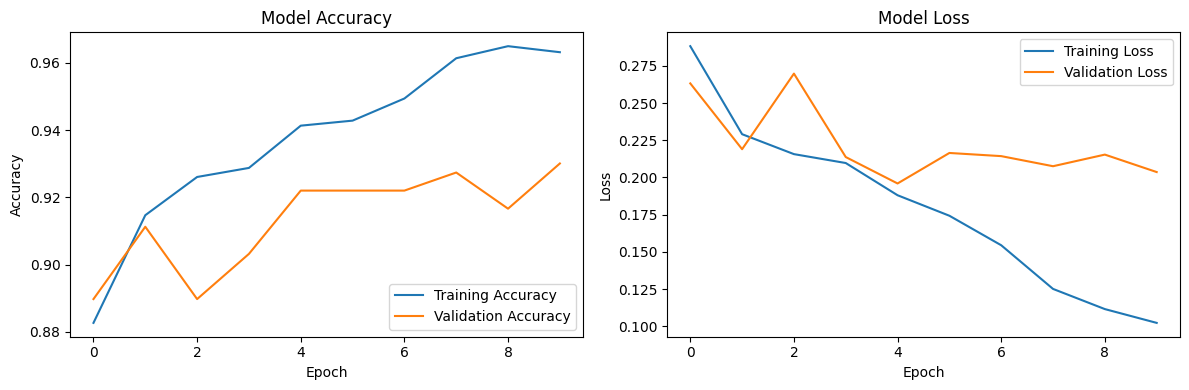

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       203
           1       0.93      0.91      0.92       169

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372



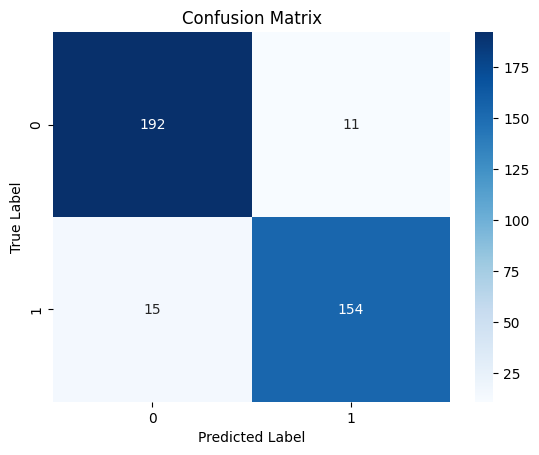

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 712ms/step - accuracy: 0.6614 - loss: 0.6626 - val_accuracy: 0.8790 - val_loss: 0.2675
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 74s 701ms/step - accuracy: 0.8497 - loss: 0.3456 - val_accuracy: 0.9086 - val_loss: 0.2418
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 707ms/step - accuracy: 0.8717 - loss: 0.3240 - val_accuracy: 0.9113 - val_loss: 0.2385
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 77s 732ms/step - accuracy: 0.8887 - loss: 0.2913 - val_accuracy: 0.9140 - val_loss: 0.2381
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 78s 741ms/step - accuracy: 0.8829 - loss: 0.2751 - val_accuracy: 0.9140 - val_loss: 0.2623
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 718ms/step - accuracy: 0.8799 - loss: 0.3166 - val_accuracy: 0.9301 - val_loss: 0.2278
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 756ms/step - accuracy: 0.9079 - loss: 0.2552 - val_accuracy: 0.9113 - val_loss: 0.2239
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 862ms/step - accuracy: 0.9165 - loss: 0

In [50]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.1855
Test Accuracy: 0.9247


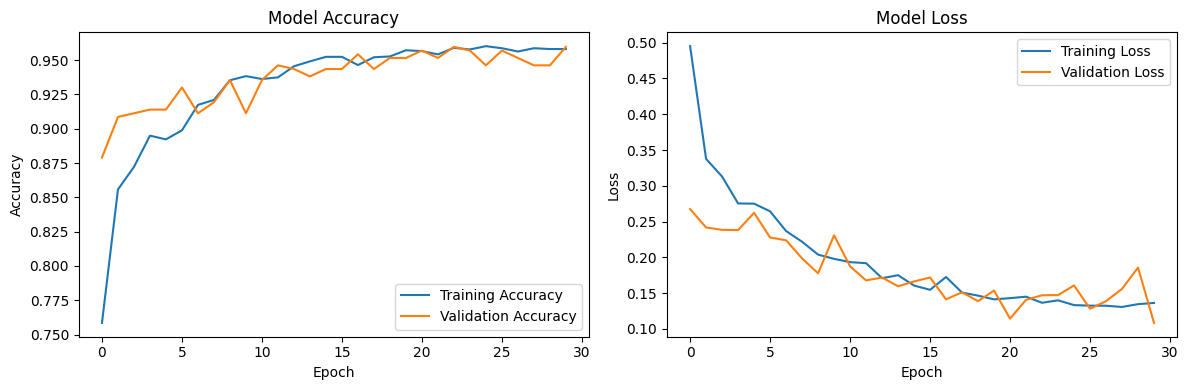

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       203
           1       0.96      0.95      0.96       169

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372



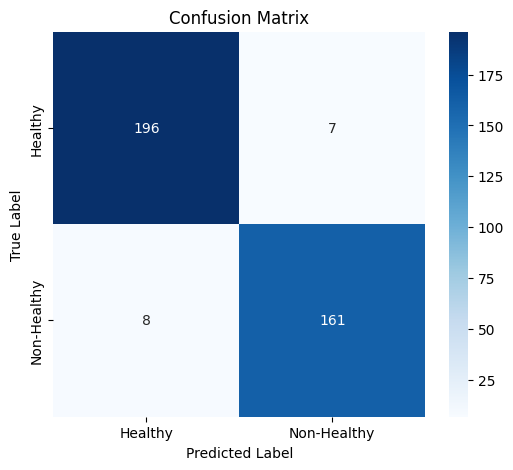

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Load pre-trained ResNet50 model

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4709 - loss: 0.7934 - val_accuracy: 0.4597 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5219 - loss: 0.7010 - val_accuracy: 0.8360 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5761 - loss: 0.6754 - val_accuracy: 0.7876 - val_loss: 0.6391 - learning_rate: 1.0000e-04
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6297 - loss: 0.6590 - val_accuracy: 0.8468 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6405 - loss: 0.6518 - val_accuracy: 0.8522 - val_loss: 0.6010 - learning_rate: 1.0000e-04
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6606 - loss: 0.6452 - val_accuracy: 0.8253 - val_loss: 0.5874 - learning_rate: 1.0000e-04
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - acc

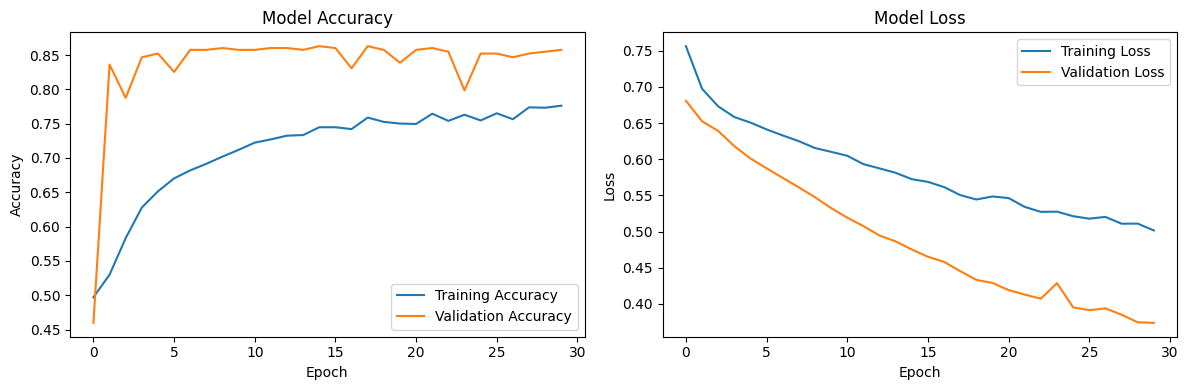

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       203
           1       0.85      0.83      0.84       169

    accuracy                           0.86       372
   macro avg       0.86      0.86      0.86       372
weighted avg       0.86      0.86      0.86       372



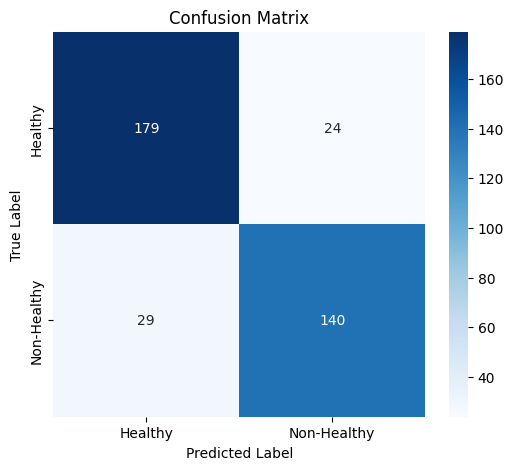

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Pre-Trained InceptionV3 Model

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_101[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_102[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_103[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)  

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 97s 868ms/step - accuracy: 0.7484 - loss: 0.5261 - val_accuracy: 0.8844 - val_loss: 0.3247 - learning_rate: 1.0000e-04
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 89s 840ms/step - accuracy: 0.8827 - loss: 0.2928 - val_accuracy: 0.8871 - val_loss: 0.2523 - learning_rate: 1.0000e-04
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 788ms/step - accuracy: 0.8919 - loss: 0.2704 - val_accuracy: 0.9032 - val_loss: 0.2187 - learning_rate: 1.0000e-04
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 800ms/step - accuracy: 0.9044 - loss: 0.2453 - val_accuracy: 0.9032 - val_loss: 0.2242 - learning_rate: 1.0000e-04
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 84s 797ms/step - accuracy: 0.9154 - loss: 0.2305 - val_accuracy: 0.9005 - val_loss: 0.2242 - learning_rate: 1.0000e-04
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 91s 865ms/step - accuracy: 0.9089 - loss: 0.2199 - val_accuracy: 0.9194 - val_loss: 0.1969 - learning_rate: 1.0000e-05
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 87

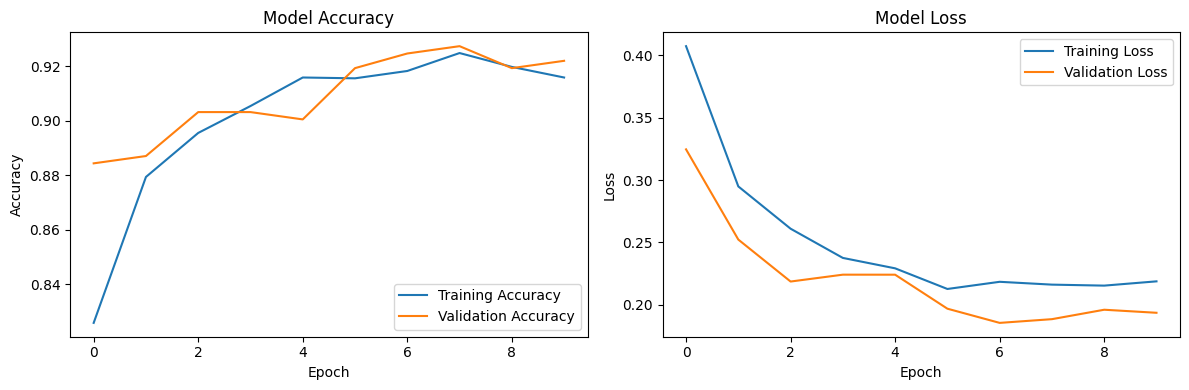

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 789ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       203
           1       0.96      0.87      0.91       169

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372



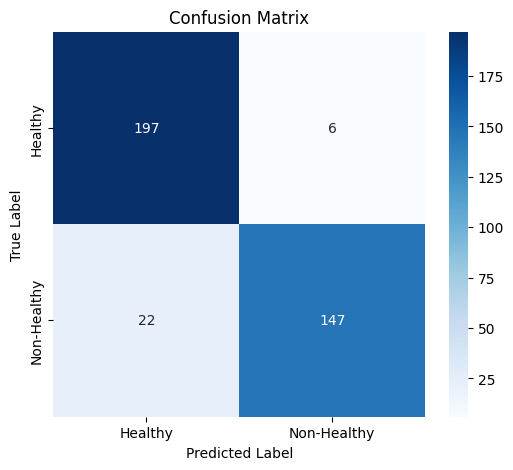

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,  # Use the augmented data generator
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save the InceptionV3 model
model.save("/content/drive/MyDrive/dataset/best_model_balanced_inceptionv3.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/dataset/best_model_balanced_inceptionv3.keras")
print("Model loaded successfully!")

# Evaluate the loaded model (optional)
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Loaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

Model loaded successfully!
Loaded Model Test Loss: 0.1855
Loaded Model Test Accuracy: 0.9247


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/dataset/best_model_balanced_inceptionv3.keras")

# Paths
test_folder = "/content/drive/MyDrive/dataset/test_images"
test_csv = "/content/drive/MyDrive/dataset/test.csv"

# Load the test CSV file
test_df = pd.read_csv(test_csv)

# Function to preprocess a single image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Non-Healthy (DR Detected)"
    else:
        return "Healthy (No DR)"

# Predict on all test images and save results
results = []
for idx, row in test_df.iterrows():
    img_name = row["id_code"] + ".png"  # Assuming images are in PNG format
    img_path = os.path.join(test_folder, img_name)
    if os.path.exists(img_path):
        result = predict_image(img_path)
        results.append((img_name, result))
    else:
        results.append((img_name, "Image Not Found"))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["id_code", "prediction"])

# Save results to a CSV file
results_df.to_csv("/content/drive/MyDrive/dataset/test_predictions.csv", index=False)
print("Predictions saved successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

Saving 0fffa73e2402.png to 0fffa73e2402 (1).png
Uploaded image: 0fffa73e2402 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


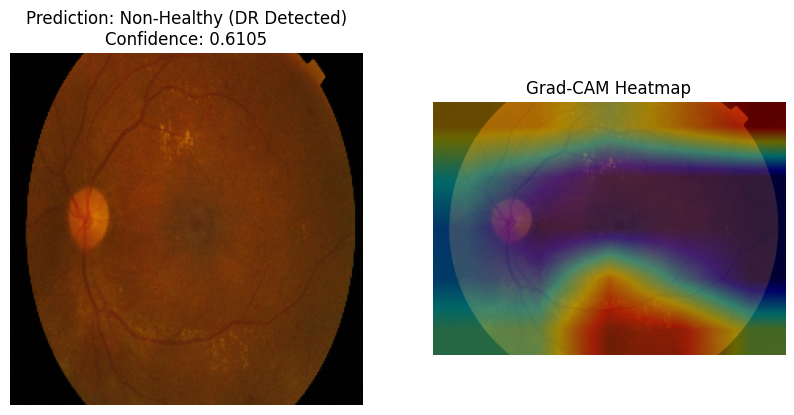

In [49]:
uploaded = files.upload()

image_name = list(uploaded.keys())[0]
print(f"Uploaded image: {image_name}")

model = load_model("/content/drive/MyDrive/dataset/best_model_balanced_inceptionv3.keras")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    confidence = prediction[0][0]
    if confidence > 0.5:
        result = "Non-Healthy (DR Detected)"
    else:
        result = "Healthy (No DR)"
    return result, confidence, img_array

def grad_cam(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img

result, confidence, img_array = predict_image(image_name)

img = image.load_img(image_name, target_size=(224, 224))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {result}\nConfidence: {confidence:.4f}")

last_conv_layer_name = "mixed10"
heatmap = grad_cam(img_array, model, last_conv_layer_name)
superimposed_img = overlay_heatmap(image_name, heatmap)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.show()